# Generate the Ground Truth Overlap
The file to generate ground truth overlaps which used in training and validation.


In [1]:
import os
import yaml
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from normalize_data import normalize_data
from tools.fileloader import load_xyz_rot
from tools.training_tools import splitting

# auto-reload external modules
%load_ext autoreload
%autoreload 2


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Configuration
Modify the configuration in *config/gen_gt_overlap.yml*.

In [2]:
# load config file
config_path = '/home/vectr/PycharmProjects/lidar_learning/configs/config.yml'
# config_path = '/Users/yanlong/PycharmProjects/lidar_learning/configs/config.yml'
parameters_path = '/home/vectr/PycharmProjects/lidar_learning/configs/parameters.yml'
# parameters_path = '/Users/yanlong/PycharmProjects/lidar_learning/configs/parameters.yml'

config = yaml.safe_load(open(config_path))
parameters = yaml.safe_load(open(parameters_path))

overlaps_folder = config['data_root']['overlaps']               # folder contain overlaps_matrix.npy
poses_folder_path = config['data_root']['poses']                # folder of positions used for trajectory plot (to select overlap_thresh)
keyframes_folder_path = config['data_root']['keyframes']        # folder of keyframes (to load keyframe position for plotting)
gt_overlaps_folder = config['data_root']['gt_overlaps']         # folder to save the overlaps and reformatted overlaps_table
lidar_params = parameters['lidar']                              # params for lidar

seq = config['seqs']['all'][6]                                  # sequences 


## Generate Overlap and Yaw Ground Truth Array

In [4]:
# load overlap matrix
overlaps_matrix_path = os.path.join(overlaps_folder, f'{seq}.bin')
overlaps_matrix = np.fromfile(overlaps_matrix_path)
overlaps_matrix = overlaps_matrix.reshape(-1, int(np.sqrt(overlaps_matrix.shape)))
print(f'Matrix shape: {overlaps_matrix.shape}')

poses_path = os.path.join(poses_folder_path, seq, 'poses.txt')
keyframes_poses_path = os.path.join(keyframes_folder_path, seq, 'poses', 'poses_kf.txt')
# poses_path = '/Users/yanlong/Desktop/overlaps/poses.txt'
xyz, rot = load_xyz_rot(poses_path)
xyz_kf, rot_kf = load_xyz_rot(keyframes_poses_path)
print(f'Number of positions: {xyz.shape}.')
print(f'Number of keyframes: {xyz_kf.shape}.')


Matrix shape: (2900, 2900)
Number of positions: (2900, 3).
Number of keyframes: (53, 3).


In [5]:
# plt.scatter(xyz[:, 0], xyz[:, 1])
# plt.show()
overlap_thresh = 0.3

%matplotlib qt
num_scans = xyz.shape[0]
for i in tqdm.tqdm(range(num_scans)):
# i = 4900
    overlaps_i = overlaps_matrix[i, :]
    xyz_pos_i = xyz[overlaps_i >= overlap_thresh, :]
    xyz_neg_i = xyz[overlaps_i < overlap_thresh, :]
    
    plt.clf()
    plt.scatter(xyz[:, 0], xyz[:, 1], c='b', label='trajectory')
    plt.scatter(xyz_pos_i[:, 0], xyz_pos_i[:, 1], c='y', label='positive')
    # plt.scatter(xyz_neg_i[:, 0], xyz_neg_i[:, 1], c='r', label='negative')
    plt.scatter(xyz_kf[:, 0], xyz_kf[:, 1], c='pink', label='keyframes')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='g', label=f'scan {i+1}')
    plt.legend()
    plt.show()
    plt.pause(0.0001)


  2%|▏         | 52/2900 [00:04<03:40, 12.92it/s]

KeyboardInterrupt



## Reformat Overlaps Matrix (to GT_Mapping)

In [68]:
# save overlaps information in a table, col0: source scan path, col1: reference scan path, col2: overlap between source and reference scans, col3: overlap threshold
overlaps = []
overlaps_table = np.empty((num_scans**2, 4))

for i in tqdm.tqdm(range(num_scans)):
    overlaps_i = np.zeros((num_scans, 4))
    overlaps_i[:, 0] = np.ones(num_scans, dtype=int) * i
    overlaps_i[:, 1] = np.arange(num_scans, dtype=int)
    overlaps_i[:, 2] = overlaps_matrix[i, :]
    overlaps_i[:, 3] = np.ones(num_scans, dtype=float) * overlap_thresh
    overlaps.append(overlaps_i)
    overlaps_table[num_scans*i:num_scans*(i+1), :] = overlaps_i

# save overlaps
gt_overlaps_saving_path = os.path.join(gt_overlaps_folder, seq)
if not os.path.exists(gt_overlaps_saving_path):
    print(f'Creating new folder {gt_overlaps_saving_path}.')
    os.makedirs(gt_overlaps_saving_path)
np.savez(os.path.join(gt_overlaps_saving_path, 'overlaps'), overlaps)

print(f'Number of pairs: {overlaps_table.shape}')

100%|██████████| 2900/2900 [00:00<00:00, 30138.66it/s]


Creating new folder /media/vectr/T9/Dataset/overlap_transformer/gt_overlaps/kerckhoff.
Number of pairs: (8410000, 4)


## Histogram of Overlaps Distribution
Plot the histogram which is used to normalize the dataset.

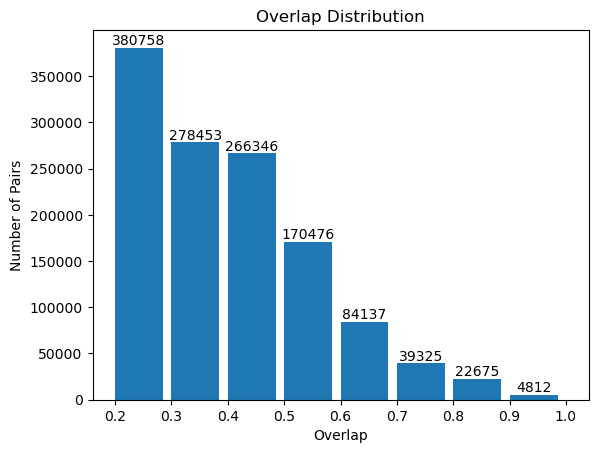

In [69]:
%matplotlib inline

# only show tail bins
min_overlap_show = 0.2
max_overlap_show = 1.0
overlaps = overlaps_table[:,2]

_, _, patches = plt.hist(overlaps[(overlaps <= max_overlap_show) & (overlaps >= min_overlap_show)], int((max_overlap_show-min_overlap_show)/0.1), width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()

## Normalize Overlaps Distribution
We need balance the number of positive and negative data pairs for training. Based on the ***Histogram*** above, select a threshold (0.5 by default) to reduce the number of negative data pairs. Moreover, we can control the number of pairs to adjust the training time.

100%|██████████| 2900/2900 [00:01<00:00, 2117.00it/s]


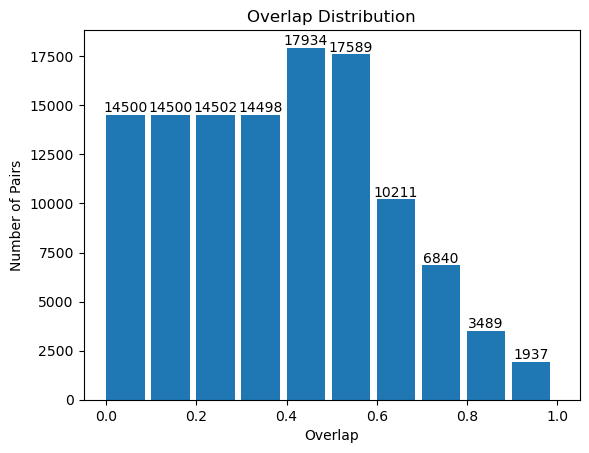

Overlaps_table_normalized shape: (116000, 4)
Number of positive pairs: 58000.
Number of negative pairs: 58000.
Select 1.38% data
Average 20.00 positive data per frame
Average 20.00 negative data per frame


In [72]:
neg_pos_threshold = round(overlap_thresh / 0.1)
max_num_pos_each_scan = 20
min_num_neg_each_scan = 5   # make sure to roughly balance the number of positive and negative pairs

overlaps_table_normalized, pos_indices, neg_indices = normalize_data(overlaps_table, max_pos_thresh=max_num_pos_each_scan, min_neg_thresh=min_num_neg_each_scan, neg_pos_threshold=neg_pos_threshold, enhance_yaw=False)
overlaps_normalized = overlaps_table_normalized[:,2]
_, _, patches = plt.hist(overlaps_normalized, 10, width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()

percent_keep = format(len(overlaps_table_normalized) / len(overlaps_table) * 100, ".2f")
num_pos = np.sum(overlaps_normalized >= neg_pos_threshold / 10)
num_neg = np.sum(overlaps_normalized < neg_pos_threshold / 10)

print(f"Overlaps_table_normalized shape: {overlaps_table_normalized.shape}")
print(f"Number of positive pairs: {num_pos}.")
print(f"Number of negative pairs: {num_neg}.")
print(f"Select {percent_keep}% data")
print(f"Average {num_pos / np.sqrt(len(overlaps_table)):.2f} positive data per frame")
print(f"Average {num_neg / np.sqrt(len(overlaps)):.2f} negative data per frame")


## Generate Training and Validation Dataset
Split the dataset to training and validation sets.

In [73]:
# split ground truth for training and validation
train_data, valid_data, _ = splitting(overlaps_table_normalized, valid_size=0.1, test_size=0.0)

# saving folder
dst_folder = gt_overlaps_saving_path

# training data
train_seq = np.empty((train_data.shape[0], 2), dtype=object)
train_seq[:] = seq
np.savez_compressed(dst_folder + f'/train_set', overlaps=train_data, seq=train_seq)

# validation data
validation_seq = np.empty((valid_data.shape[0], 2), dtype=object)
validation_seq[:] = seq
np.savez_compressed(dst_folder + f'/valid_set', overlaps=valid_data, seq=validation_seq)

# normalized ground truth data
overlaps_table_normalized_seq = np.empty((overlaps_table_normalized.shape[0], 2), dtype=object)
overlaps_table_normalized_seq[:] = seq
np.savez_compressed(dst_folder + f'/overlaps_table_normalized', overlaps=overlaps_table_normalized, seq=overlaps_table_normalized_seq)

# raw ground truth data, fully mapping, could be used for testing
overlaps_table_seq = np.empty((overlaps_table.shape[0], 2), dtype=object)
overlaps_table_seq[:] = seq
np.savez_compressed(dst_folder + f'/overlaps_table', overlaps=overlaps_table, seq=overlaps_table_seq)

print(f'Finish saving the ground truth data for training and testing at: {os.path.abspath(dst_folder)} \n')
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f'Distribution Norm set shape: {overlaps_normalized.shape}')


Finish saving the ground truth data for training and testing at: /media/vectr/T9/Dataset/overlap_transformer/gt_overlaps/kerckhoff 

Training set shape: (104400, 4)
Validation set shape: (11600, 4)
Distribution Norm set shape: (116000,)


## Visualize Generate Dataset (Option)
Visualize the generated overlaps for a frame.

In [55]:
%matplotlib qt
num_scans = xyz.shape[0]
for i in tqdm.tqdm(range(num_scans)):
    overlaps_i = overlaps_matrix[i, :]
    curr_pos_indices = pos_indices[i]
    curr_neg_indices = neg_indices[i]
    xyz_curr_pos = xyz[curr_pos_indices, :]
    xyz_curr_neg = xyz[curr_neg_indices, :]
    
    plt.clf()
    plt.scatter(xyz[:, 0], xyz[:, 1], c='b', label='trajectory')
    plt.scatter(xyz_curr_pos[:, 0], xyz_curr_pos[:, 1], c='y', label='positive')
    plt.scatter(xyz_curr_neg[:, 0], xyz_curr_neg[:, 1], c='r', label='negative')
    # plt.scatter(xyz_kf[:, 0], xyz_kf[:, 1], c='pink', label='keyframes')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='g', label=f'scan {i+1}')
    plt.legend()
    plt.show()
    plt.pause(0.0001)


 18%|█▊        | 927/5207 [01:25<06:35, 10.83it/s]


KeyboardInterrupt: 

In [ ]:
# format the data in table to load data efficiently
# max_num_pos = 100, max_num_neg = 100, col0: curr_scan_id, col1: seq, col2:overlap_threshold, col3: num_pos, col4: num_neg, col5-104: pos_ids, col105-204: neg_ids
# (add overlaps in col205:404 if needed)
# matrix shape: (num_scans, 5+max_num_pos+max_num_neg)
overlaps_full = -np.ones((num_scans, 205))
overlaps_train = -np.ones((train_data.shape[0], 205))
overlaps_valid = -np.ones((valid_data.shape[0], 205))
